## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp009'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    start = 0
    end = CFG.in_chans
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

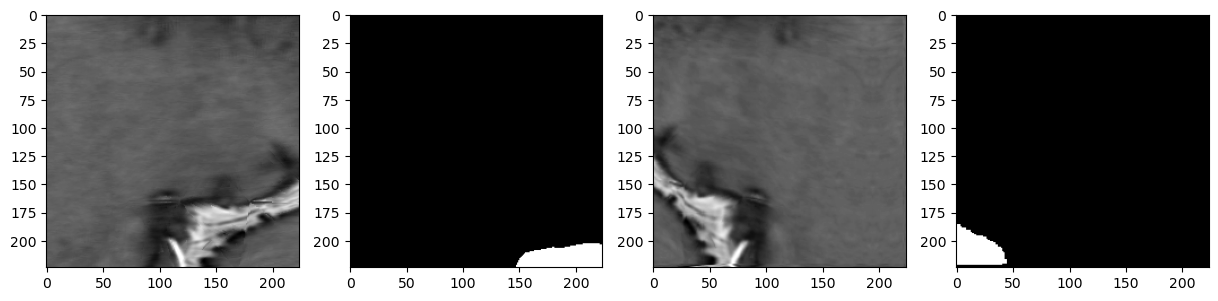

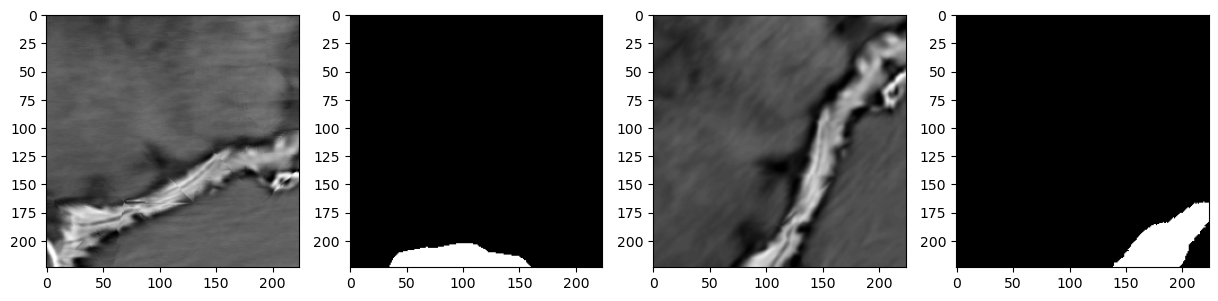

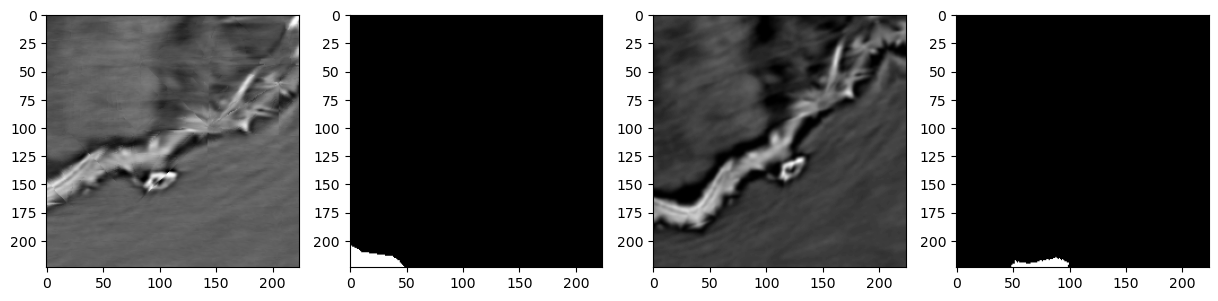

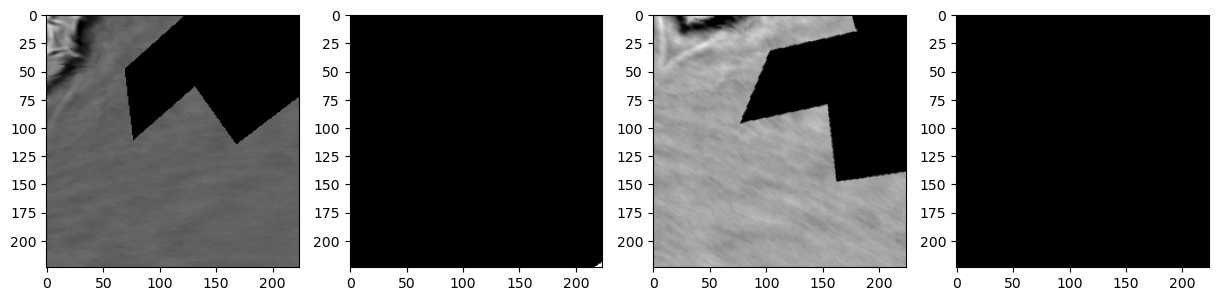

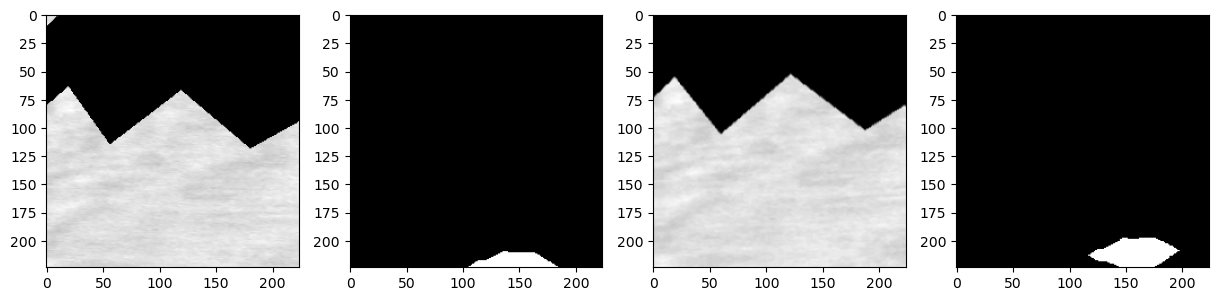

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.21655890973553837
th: 0.15, fbeta: 0.23264452849677936
th: 0.2, fbeta: 0.2374148067957343
th: 0.25, fbeta: 0.2383431344705268
th: 0.3, fbeta: 0.23458303057005006
th: 0.35, fbeta: 0.21184149147159928
th: 0.4, fbeta: 0.1418063349030721
th: 0.45, fbeta: 0.05219835485489188


best_th: 0.25, fbeta: 0.2383431344705268
Epoch 1 - avg_train_loss: 0.4060  avg_val_loss: 0.3105  time: 226s
Epoch 1 - avgScore: 0.2383
Epoch 1 - Save Best Score: 0.2383 Model
Epoch 1 - Save Best Loss: 0.3105 Model


th: 0.5, fbeta: 0.010944337250771194


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2404148712936609
th: 0.15, fbeta: 0.24428786905398958
th: 0.2, fbeta: 0.23869406934850143
th: 0.25, fbeta: 0.21743744242537827
th: 0.3, fbeta: 0.14580950041815097
th: 0.35, fbeta: 0.03626476505959411
th: 0.4, fbeta: 0.004247365653415423
th: 0.45, fbeta: 0.0004973294302894112


best_th: 0.15, fbeta: 0.24428786905398958
Epoch 2 - avg_train_loss: 0.3207  avg_val_loss: 0.2823  time: 229s
Epoch 2 - avgScore: 0.2443
Epoch 2 - Save Best Score: 0.2443 Model
Epoch 2 - Save Best Loss: 0.2823 Model


th: 0.5, fbeta: 6.552881162910861e-05


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.22012988984790638
th: 0.15, fbeta: 0.19399900104209525
th: 0.2, fbeta: 0.05831128584919693
th: 0.25, fbeta: 0.00020861407065464758
th: 0.3, fbeta: 1.4045465344954024e-05
th: 0.35, fbeta: 1.8728045198021714e-06
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.22012988984790638
Epoch 3 - avg_train_loss: 0.2918  avg_val_loss: 0.2922  time: 228s
Epoch 3 - avgScore: 0.2201


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23886423445335053
th: 0.15, fbeta: 0.21889146063477094
th: 0.2, fbeta: 0.1965310885468731
th: 0.25, fbeta: 0.013419760077423971
th: 0.3, fbeta: 4.213495002801221e-05
th: 0.35, fbeta: 2.8092046754540447e-06
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.23886423445335053
Epoch 4 - avg_train_loss: 0.2856  avg_val_loss: 0.2673  time: 227s
Epoch 4 - avgScore: 0.2389


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24306928267816413
th: 0.15, fbeta: 0.21205406008683406
th: 0.2, fbeta: 0.09091924964091426
th: 0.25, fbeta: 7.206656155097316e-05
th: 0.3, fbeta: 9.36326655267054e-07
th: 0.35, fbeta: 0.0
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.24306928267816413
Epoch 5 - avg_train_loss: 0.2834  avg_val_loss: 0.2666  time: 228s
Epoch 5 - avgScore: 0.2431


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22825431562761064
th: 0.15, fbeta: 0.18286925422399639
th: 0.2, fbeta: 0.09232492554832201
th: 0.25, fbeta: 0.013451331633926481
th: 0.3, fbeta: 1.8728045198021714e-06
th: 0.35, fbeta: 0.0
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.22825431562761064
Epoch 6 - avg_train_loss: 0.2823  avg_val_loss: 0.2777  time: 228s
Epoch 6 - avgScore: 0.2283


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24287864794741318
th: 0.15, fbeta: 0.20354267547227178
th: 0.2, fbeta: 0.061625440159458644
th: 0.25, fbeta: 1.3303169229365382e-05
th: 0.3, fbeta: 0.0
th: 0.35, fbeta: 0.0
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.24287864794741318
Epoch 7 - avg_train_loss: 0.2822  avg_val_loss: 0.2686  time: 228s
Epoch 7 - avgScore: 0.2429


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24422467698779662
th: 0.15, fbeta: 0.22916104123565456
th: 0.2, fbeta: 0.17325970033386104
th: 0.25, fbeta: 0.0825856429241337
th: 0.3, fbeta: 0.0004964173344616183
th: 0.35, fbeta: 0.0
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.24422467698779662
Epoch 8 - avg_train_loss: 0.2797  avg_val_loss: 0.2647  time: 230s
Epoch 8 - avgScore: 0.2442


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24195031743945442
th: 0.15, fbeta: 0.23441269340606588
th: 0.2, fbeta: 0.21518856650676896
th: 0.25, fbeta: 0.1708004179647547
th: 0.3, fbeta: 0.0736200232239496
th: 0.35, fbeta: 8.42700720977769e-06
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.24195031743945442
Epoch 9 - avg_train_loss: 0.2773  avg_val_loss: 0.2661  time: 227s
Epoch 9 - avgScore: 0.2420


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24347201396304058
th: 0.15, fbeta: 0.22852342244009122
th: 0.2, fbeta: 0.20156392997396397
th: 0.25, fbeta: 0.15410968698334152
th: 0.3, fbeta: 0.0856116434235288
th: 0.35, fbeta: 0.002366000735039831
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.24347201396304058
Epoch 10 - avg_train_loss: 0.2754  avg_val_loss: 0.2685  time: 228s
Epoch 10 - avgScore: 0.2435


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24293953482458736
th: 0.15, fbeta: 0.24481201882958156
th: 0.2, fbeta: 0.24085832271923302
th: 0.25, fbeta: 0.13826414474166474
th: 0.3, fbeta: 0.03910817529664378
th: 0.35, fbeta: 0.0011557984569960337
th: 0.4, fbeta: 1.864287259979137e-05
th: 0.45, fbeta: 0.0


best_th: 0.15, fbeta: 0.24481201882958156
Epoch 11 - avg_train_loss: 0.2720  avg_val_loss: 0.2669  time: 231s
Epoch 11 - avgScore: 0.2448
Epoch 11 - Save Best Score: 0.2448 Model
Epoch 11 - Save Best Loss: 0.2669 Model


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23807641374323868
th: 0.15, fbeta: 0.21609993344703035
th: 0.2, fbeta: 0.1318625428618212
th: 0.25, fbeta: 0.07429389309978988
th: 0.3, fbeta: 0.030368995434090332
th: 0.35, fbeta: 0.013634269017801823
th: 0.4, fbeta: 0.005034466711520435
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.23807641374323868
Epoch 12 - avg_train_loss: 0.2680  avg_val_loss: 0.2857  time: 228s
Epoch 12 - avgScore: 0.2381


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24236209224497213
th: 0.15, fbeta: 0.2395959156622046
th: 0.2, fbeta: 0.23795215890232332
th: 0.25, fbeta: 0.22818507786697012
th: 0.3, fbeta: 0.2183764994490956
th: 0.35, fbeta: 0.19775058714095198
th: 0.4, fbeta: 0.15244773365862957
th: 0.45, fbeta: 0.0940093453742908


best_th: 0.1, fbeta: 0.24236209224497213
Epoch 13 - avg_train_loss: 0.2630  avg_val_loss: 0.2837  time: 230s
Epoch 13 - avgScore: 0.2424


th: 0.5, fbeta: 0.03897241263572819


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23486881384079591
th: 0.15, fbeta: 0.21043131207774374
th: 0.2, fbeta: 0.17753876795998735
th: 0.25, fbeta: 0.08217593722848024
th: 0.3, fbeta: 0.015927211749639063
th: 0.35, fbeta: 0.0007874117861523525
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.1, fbeta: 0.23486881384079591
Epoch 14 - avg_train_loss: 0.2591  avg_val_loss: 0.2948  time: 230s
Epoch 14 - avgScore: 0.2349


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24422591377146866
th: 0.15, fbeta: 0.23386325248692108
th: 0.2, fbeta: 0.2145723315914604
th: 0.25, fbeta: 0.1861256309094748
th: 0.3, fbeta: 0.16416653446646376
th: 0.35, fbeta: 0.13489779544508593
th: 0.4, fbeta: 0.09692470283528798
th: 0.45, fbeta: 0.05811617248679253


best_th: 0.1, fbeta: 0.24422591377146866
Epoch 15 - avg_train_loss: 0.2522  avg_val_loss: 0.2916  time: 228s
Epoch 15 - avgScore: 0.2442


th: 0.5, fbeta: 0.03370234074058582


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2503499027258583
th: 0.15, fbeta: 0.2413165680423132
th: 0.2, fbeta: 0.21621356909256215
th: 0.25, fbeta: 0.18591013311817414
th: 0.3, fbeta: 0.1429165237603314
th: 0.35, fbeta: 0.0990156833889103
th: 0.4, fbeta: 0.057408368755848434
th: 0.45, fbeta: 0.03529174148625861


best_th: 0.1, fbeta: 0.2503499027258583
Epoch 16 - avg_train_loss: 0.2454  avg_val_loss: 0.3070  time: 231s
Epoch 16 - avgScore: 0.2503
Epoch 16 - Save Best Score: 0.2503 Model
Epoch 16 - Save Best Loss: 0.3070 Model


th: 0.5, fbeta: 0.022307647661308744


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2222178830694248
th: 0.15, fbeta: 0.20857493632328655
th: 0.2, fbeta: 0.17191006977919593
th: 0.25, fbeta: 0.1347666078050365
th: 0.3, fbeta: 0.09083689766298006
th: 0.35, fbeta: 0.04716847225537301
th: 0.4, fbeta: 0.021162164245731578
th: 0.45, fbeta: 0.008438302315345945


best_th: 0.1, fbeta: 0.2222178830694248
Epoch 17 - avg_train_loss: 0.2383  avg_val_loss: 0.3261  time: 229s
Epoch 17 - avgScore: 0.2222


th: 0.5, fbeta: 0.0017289212441567762


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19320796723157158
th: 0.15, fbeta: 0.17557159483047477
th: 0.2, fbeta: 0.14761541455887858
th: 0.25, fbeta: 0.11222481470325106
th: 0.3, fbeta: 0.07858581897659268
th: 0.35, fbeta: 0.05307006109150559
th: 0.4, fbeta: 0.0365386605922579
th: 0.45, fbeta: 0.01723077912937342


best_th: 0.1, fbeta: 0.19320796723157158
Epoch 18 - avg_train_loss: 0.2279  avg_val_loss: 0.3724  time: 227s
Epoch 18 - avgScore: 0.1932


th: 0.5, fbeta: 0.007064964199358511


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22661223074344342
th: 0.15, fbeta: 0.21350046197553232
th: 0.2, fbeta: 0.20162456292522257
th: 0.25, fbeta: 0.18174703472096906
th: 0.3, fbeta: 0.1605795553878899
th: 0.35, fbeta: 0.13609170054269498
th: 0.4, fbeta: 0.11535714951913714
th: 0.45, fbeta: 0.091352329396105


best_th: 0.1, fbeta: 0.22661223074344342
Epoch 19 - avg_train_loss: 0.2211  avg_val_loss: 0.3312  time: 232s
Epoch 19 - avgScore: 0.2266


th: 0.5, fbeta: 0.05997702620252231


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.17284175813826747
th: 0.15, fbeta: 0.1387013650724575
th: 0.2, fbeta: 0.11309387739099064
th: 0.25, fbeta: 0.07451266131463236
th: 0.3, fbeta: 0.050516754346815504
th: 0.35, fbeta: 0.033959628382600644
th: 0.4, fbeta: 0.0210346583916882
th: 0.45, fbeta: 0.009967541840469342


best_th: 0.1, fbeta: 0.17284175813826747
Epoch 20 - avg_train_loss: 0.2121  avg_val_loss: 0.3922  time: 230s
Epoch 20 - avgScore: 0.1728


th: 0.5, fbeta: 0.0033335262253539814


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23753456974315526
th: 0.15, fbeta: 0.2311181380979481
th: 0.2, fbeta: 0.22113868297896752
th: 0.25, fbeta: 0.20806189956262358
th: 0.3, fbeta: 0.19414156676776842
th: 0.35, fbeta: 0.18229186177727258
th: 0.4, fbeta: 0.1707420159133005
th: 0.45, fbeta: 0.14768512760367677


best_th: 0.1, fbeta: 0.23753456974315526
Epoch 21 - avg_train_loss: 0.2032  avg_val_loss: 0.3545  time: 229s
Epoch 21 - avgScore: 0.2375


th: 0.5, fbeta: 0.12149080298487183


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22726714548798926
th: 0.15, fbeta: 0.21721154080642519
th: 0.2, fbeta: 0.20276373795354927
th: 0.25, fbeta: 0.18988807085553985
th: 0.3, fbeta: 0.18094736533306144
th: 0.35, fbeta: 0.16700957924595636
th: 0.4, fbeta: 0.15282945859076508
th: 0.45, fbeta: 0.13869300893705144


best_th: 0.1, fbeta: 0.22726714548798926
Epoch 22 - avg_train_loss: 0.1963  avg_val_loss: 0.3740  time: 230s
Epoch 22 - avgScore: 0.2273


th: 0.5, fbeta: 0.12612669815969854


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23294516805605775
th: 0.15, fbeta: 0.2216325383514818
th: 0.2, fbeta: 0.19992114553857215
th: 0.25, fbeta: 0.17572586238843815
th: 0.3, fbeta: 0.15657738608582908
th: 0.35, fbeta: 0.13546688715648952
th: 0.4, fbeta: 0.11722368922786229
th: 0.45, fbeta: 0.09473366140146826


best_th: 0.1, fbeta: 0.23294516805605775
Epoch 23 - avg_train_loss: 0.1894  avg_val_loss: 0.3795  time: 228s
Epoch 23 - avgScore: 0.2329


th: 0.5, fbeta: 0.07048502677575375


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.18881644456388483
th: 0.15, fbeta: 0.1535218018519853
th: 0.2, fbeta: 0.13199909548269312
th: 0.25, fbeta: 0.10606252071791607
th: 0.3, fbeta: 0.08946389115825244
th: 0.35, fbeta: 0.07564059135200635
th: 0.4, fbeta: 0.059350591079528
th: 0.45, fbeta: 0.04435958626277728


best_th: 0.1, fbeta: 0.18881644456388483
Epoch 24 - avg_train_loss: 0.1813  avg_val_loss: 0.4230  time: 231s
Epoch 24 - avgScore: 0.1888


th: 0.5, fbeta: 0.03051231655682761


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2160326058594631
th: 0.15, fbeta: 0.18617740629257926
th: 0.2, fbeta: 0.15718837303714311
th: 0.25, fbeta: 0.13272985162810538
th: 0.3, fbeta: 0.11514165619609994
th: 0.35, fbeta: 0.09068944040172239
th: 0.4, fbeta: 0.06730297906526905
th: 0.45, fbeta: 0.04501425794878277


best_th: 0.1, fbeta: 0.2160326058594631
Epoch 25 - avg_train_loss: 0.1756  avg_val_loss: 0.4245  time: 231s
Epoch 25 - avgScore: 0.2160


th: 0.5, fbeta: 0.026835439262904836


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2337611994233511
th: 0.15, fbeta: 0.2277921929911484
th: 0.2, fbeta: 0.2119541201661955
th: 0.25, fbeta: 0.19120016844006085
th: 0.3, fbeta: 0.1711269607009276
th: 0.35, fbeta: 0.15138801674668734
th: 0.4, fbeta: 0.13106509724721357
th: 0.45, fbeta: 0.11187769505674613


best_th: 0.1, fbeta: 0.2337611994233511
Epoch 26 - avg_train_loss: 0.1718  avg_val_loss: 0.4109  time: 229s
Epoch 26 - avgScore: 0.2338


th: 0.5, fbeta: 0.09339321694678959


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21842189696430253
th: 0.15, fbeta: 0.20065783324671413
th: 0.2, fbeta: 0.17855316067055052
th: 0.25, fbeta: 0.16007279309194916
th: 0.3, fbeta: 0.13859421643110037
th: 0.35, fbeta: 0.11457216583606342
th: 0.4, fbeta: 0.09511360507622788
th: 0.45, fbeta: 0.08146340950271246


best_th: 0.1, fbeta: 0.21842189696430253
Epoch 27 - avg_train_loss: 0.1669  avg_val_loss: 0.4430  time: 231s
Epoch 27 - avgScore: 0.2184


th: 0.5, fbeta: 0.06623554430073772


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2259283524178918
th: 0.15, fbeta: 0.21115901410586227
th: 0.2, fbeta: 0.19024357960957777
th: 0.25, fbeta: 0.16674078905813874
th: 0.3, fbeta: 0.14639268716905146
th: 0.35, fbeta: 0.12694764159104743
th: 0.4, fbeta: 0.11036710983911466
th: 0.45, fbeta: 0.09558640266551521


best_th: 0.1, fbeta: 0.2259283524178918
Epoch 28 - avg_train_loss: 0.1639  avg_val_loss: 0.4382  time: 229s
Epoch 28 - avgScore: 0.2259


th: 0.5, fbeta: 0.0772942210224609


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21920384286606234
th: 0.15, fbeta: 0.20286201122063993
th: 0.2, fbeta: 0.18455378211870715
th: 0.25, fbeta: 0.16667351880393752
th: 0.3, fbeta: 0.14731540139998042
th: 0.35, fbeta: 0.12658135263705594
th: 0.4, fbeta: 0.11078177135816462
th: 0.45, fbeta: 0.09930984967843423


best_th: 0.1, fbeta: 0.21920384286606234
Epoch 29 - avg_train_loss: 0.1618  avg_val_loss: 0.4373  time: 228s
Epoch 29 - avgScore: 0.2192


th: 0.5, fbeta: 0.08673521167300716


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2190077896876891
th: 0.15, fbeta: 0.1992751433165792
th: 0.2, fbeta: 0.17834567021623896
th: 0.25, fbeta: 0.15562638702967369
th: 0.3, fbeta: 0.139883960725555
th: 0.35, fbeta: 0.12737900040885475
th: 0.4, fbeta: 0.1125194260647124
th: 0.45, fbeta: 0.09209902057162117


best_th: 0.1, fbeta: 0.2190077896876891
Epoch 30 - avg_train_loss: 0.1603  avg_val_loss: 0.4265  time: 231s
Epoch 30 - avgScore: 0.2190


th: 0.5, fbeta: 0.07733843673872579


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.2503499027258583
th: 0.15, fbeta: 0.2413165680423132
th: 0.2, fbeta: 0.21621356909256215
th: 0.25, fbeta: 0.18591013311817414
th: 0.3, fbeta: 0.1429165237603314
th: 0.35, fbeta: 0.0990156833889103
th: 0.4, fbeta: 0.057408368755848434
th: 0.45, fbeta: 0.03529174148625861


best_th: 0.1, fbeta: 0.2503499027258583


th: 0.5, fbeta: 0.022307647661308744


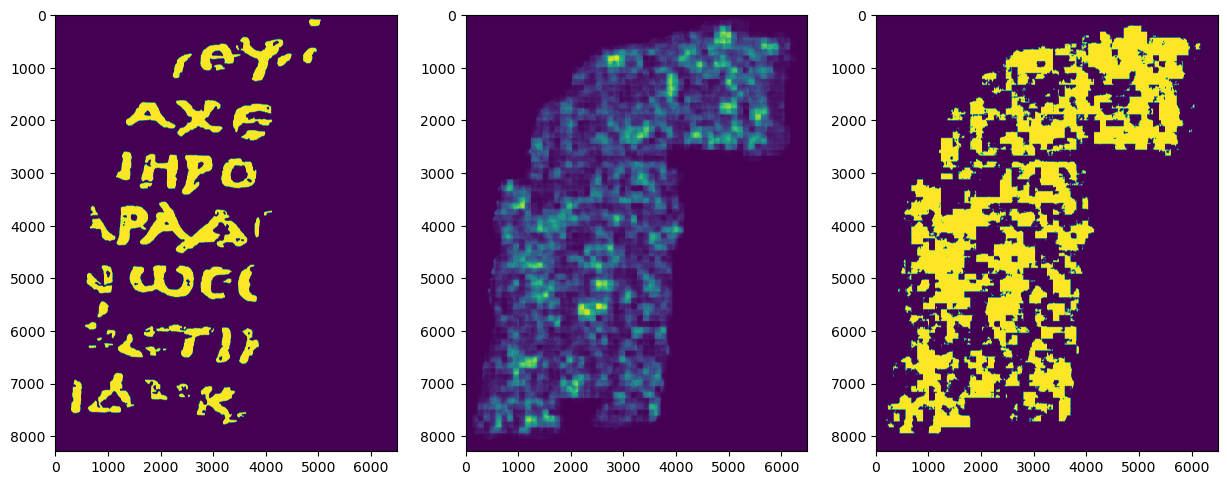

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.0064625e+07, 5.4832920e+06, 4.3814760e+06, 3.2978400e+06,
        2.5267450e+06, 2.0267890e+06, 1.5204240e+06, 1.1716350e+06,
        9.3846000e+05, 7.1702400e+05, 4.9545900e+05, 3.4650000e+05,
        2.6744900e+05, 2.0452300e+05, 1.5533500e+05, 1.1224400e+05,
        6.7275000e+04, 3.0650000e+04, 2.5143000e+04, 5.9600000e+03]),
 array([1.42831648e-08, 3.23276931e-02, 6.46553719e-02, 9.69830508e-02,
        1.29310730e-01, 1.61638408e-01, 1.93966087e-01, 2.26293766e-01,
        2.58621445e-01, 2.90949124e-01, 3.23276803e-01, 3.55604481e-01,
        3.87932160e-01, 4.20259839e-01, 4.52587518e-01, 4.84915197e-01,
        5.17242876e-01, 5.49570554e-01, 5.81898233e-01, 6.14225912e-01,
        6.46553591e-01]),
 <BarContainer object of 20 artists>)

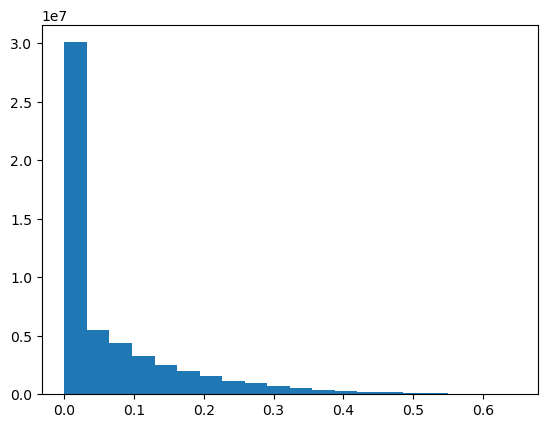

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000